### 几个发现

- bitmex似乎只能查到最近几天的交易和委托历史。在10月27日下午18点登录网页查看，只能查到10月22日以来的交易记录和委托记录
- textnet测试发现，已撤单的订单在大约10分钟之后会消失，网页端和REST-API(/execution)都查不到了。
- 实盘成交价格可能会超出REST-API查询的历史k线范围。已用实盘交易记录验证（自营账户10月24日4笔买单）

In [1]:
startTime = '2018-10-10 00:00:00'
endTime = None
symbol = 'XBTUSD'
bar_type = '1h'

account_settings_file = '../bitmex/BITMEX_connect.json'
which = 'tinghao_real_trading'  #'account_test'

In [2]:
from bitmex.bitmexREST import bitmexREST
from bitmex.bitmexAccountSettings import bitmexAccountSettings

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",101)

In [3]:
acc = bitmexAccountSettings()
acc.from_config_file(account_settings_file, which)

In [4]:
rest = bitmexREST(apiKey=acc.apiKey, apiSecret=acc.apiSecret, isTestNet=acc.isTestNet)

execution_result = rest.query_history_execution(symbol, startTime, endTime)

df_exec = pd.DataFrame(execution_result)
df_exec['DATETIME'] = pd.to_datetime(df_exec['transactTime'])
df_exec.head()

,account,avgPx,clOrdID,clOrdLinkID,commission,contingencyType,cumQty,currency,displayQty,exDestination,execComm,execCost,execID,execInst,execType,foreignNotional,homeNotional,lastLiquidityInd,lastMkt,lastPx,lastQty,leavesQty,multiLegReportingType,ordRejReason,ordStatus,ordType,orderID,orderQty,pegOffsetValue,pegPriceType,price,settlCurrency,side,simpleCumQty,simpleLeavesQty,simpleOrderQty,stopPx,symbol,text,timeInForce,timestamp,tradePublishIndicator,transactTime,trdMatchID,triggered,underlyingLastPx,workingIndicator,DATETIME
0,295078,6413.34,,,0.00010,,10713,USD,None,XBME,16704,-167037096,5fdc0563-60e9-2ebb-866a-b9ddf92d776a,,Funding,-10713,1.670371,,XBME,6413.34,10713,0,SingleSecurity,,Filled,Limit,00000000-0000-0000-0000-000000000000,10713,None,,6413.34,XBt,,1.66400,0.0,None,None,XBTUSD,Funding,AtTheClose,2018-10-22T04:00:00.101Z,,2018-10-22T04:00:00.000Z,73b20bc0-dd74-3072-1324-054209987724,,None,False,2018-10-22 04:00:00.000
1,295078,6399.85,,,0.00010,,10713,USD,None,XBME,16739,-167390625,e752b29c-982b-ce9c-4546-e28889df269d,,Funding,-10713,1.673906,,XBME,6399.85,10713,0,SingleSecurity,,Filled,Limit,00000000-0000-0000-0000-000000000000,10713,None,,6399.85,XBt,,1.66400,0.0,None,None,XBTUSD,Funding,AtTheClose,2018-10-22T12:00:01.003Z,,2018-10-22T12:00:00.000Z,95ef205a-b5a6-f232-5dd8-1938d938fe2e,,None,False,2018-10-22 12:00:00.000
2,295078,6382.50,,,0.00075,,11274,USD,None,XBME,132480,176641032,0ad260ce-845f-ebaa-f02a-cdbe3c257ff2,,Trade,11274,-1.766410,RemovedLiquidity,XBME,6382.50,11274,0,SingleSecurity,,Filled,Limit,6232c016-3495-8f56-16e6-7cfdda13afe8,11274,None,,6368.00,XBt,Sell,1.75119,0.0,None,None,XBTUSD,Submitted via API.,GoodTillCancel,2018-10-22T13:15:58.019Z,PublishTrade,2018-10-22T13:15:58.019Z,488bfc3d-d14c-7931-914d-987d69f8401f,,None,False,2018-10-22 13:15:58.019
3,295078,6391.60,,,-0.00010,,561,USD,None,XBME,-878,8777406,8f22468f-5a22-425d-9e61-e4b0cfbe1f02,,Funding,561,-0.087774,,XBME,6391.60,561,0,SingleSecurity,,Filled,Limit,00000000-0000-0000-0000-000000000000,561,None,,6391.60,XBt,,0.08790,0.0,None,None,XBTUSD,Funding,AtTheClose,2018-10-22T20:00:00.102Z,,2018-10-22T20:00:00.000Z,35ba413b-a3b0-3705-14f8-fc34c32e4d7e,,None,False,2018-10-22 20:00:00.000
4,295078,6393.13,,,-0.00010,,561,USD,None,XBME,-878,8775162,e078d30c-5620-0e5b-13c0-fa3fd140e710,,Funding,561,-0.087752,,XBME,6393.13,561,0,SingleSecurity,,Filled,Limit,00000000-0000-0000-0000-000000000000,561,None,,6393.13,XBt,,0.08790,0.0,None,None,XBTUSD,Funding,AtTheClose,2018-10-23T04:00:00.095Z,,2018-10-23T04:00:00.000Z,9f3b6fe2-2d24-55dd-70ac-9817ef8c33aa,,None,False,2018-10-23 04:00:00.000


In [5]:
all(df_exec.transactTime <= df_exec.timestamp)  # True

True

In [6]:
df_exec.columns

Index(['account', 'avgPx', 'clOrdID', 'clOrdLinkID', 'commission',
       'contingencyType', 'cumQty', 'currency', 'displayQty', 'exDestination',
       'execComm', 'execCost', 'execID', 'execInst', 'execType',
       'foreignNotional', 'homeNotional', 'lastLiquidityInd', 'lastMkt',
       'lastPx', 'lastQty', 'leavesQty', 'multiLegReportingType',
       'ordRejReason', 'ordStatus', 'ordType', 'orderID', 'orderQty',
       'pegOffsetValue', 'pegPriceType', 'price', 'settlCurrency', 'side',
       'simpleCumQty', 'simpleLeavesQty', 'simpleOrderQty', 'stopPx', 'symbol',
       'text', 'timeInForce', 'timestamp', 'tradePublishIndicator',
       'transactTime', 'trdMatchID', 'triggered', 'underlyingLastPx',
       'workingIndicator', 'DATETIME'],
      dtype='object')

In [7]:
rest_no_auth = bitmexREST(None, None, True)
market_result = rest_no_auth.query_history_bars(symbol, startTime, endTime, bar_type)

df_market = pd.DataFrame(market_result)
df_market['DATETIME'] = pd.to_datetime(df_market['timestamp'])
df_market.head()

,close,foreignNotional,high,homeNotional,lastSize,low,open,symbol,timestamp,trades,turnover,volume,vwap,DATETIME
0,6601.0,4708734,6613.5,713.236881,430,6588.0,6594.5,XBTUSD,2018-10-10T00:00:00.000Z,2704,71323688072,4708734,6601.9674,2018-10-10 00:00:00
1,6593.5,4129738,6622.5,625.379000,863,6591.5,6601.0,XBTUSD,2018-10-10T01:00:00.000Z,1781,62537900044,4129738,6603.7113,2018-10-10 01:00:00
2,6581.0,6853561,6593.5,1040.678965,55,6580.5,6593.5,XBTUSD,2018-10-10T02:00:00.000Z,1873,104067896451,6853561,6585.8799,2018-10-10 02:00:00
3,6577.5,4400846,6590.0,668.864897,70436,6568.5,6581.0,XBTUSD,2018-10-10T03:00:00.000Z,1940,66886489666,4400846,6579.8131,2018-10-10 03:00:00
4,6542.5,14079432,6584.5,2148.317836,47271,6535.0,6577.5,XBTUSD,2018-10-10T04:00:00.000Z,4804,214831783553,14079432,6553.9389,2018-10-10 04:00:00


(<matplotlib.collections.LineCollection at 0x10a5473c8>,
 <matplotlib.collections.PolyCollection at 0x10a5472e8>)

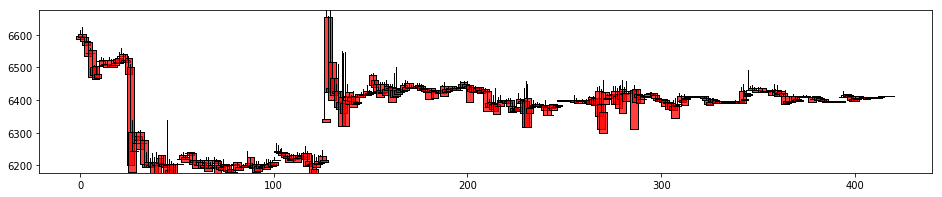

In [8]:
from matplotlib.finance import candlestick2_ohlc
# matplotlib.finance.candlestick2_ochl(ax, opens, closes, highs, lows, width=4, colorup='k', colordown='r', alpha=0.75)

fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)

candlestick2_ohlc(ax, df_market['open'], df_market['close'], df_market['high'], df_market['low'])

In [9]:
df_Exec_Trade_Buy = df_exec.query('execType == "Trade" & side=="Buy"')
df_Exec_Trade_Sell = df_exec.query('execType == "Trade" & side=="Sell"')

df_Exec_New = df_exec.query('execType == "New"')
df_Exec_Canceled = df_exec.query('execType == "Canceled"')

In [10]:
df_Exec_Trade_Buy

,account,avgPx,clOrdID,clOrdLinkID,commission,contingencyType,cumQty,currency,displayQty,exDestination,execComm,execCost,execID,execInst,execType,foreignNotional,homeNotional,lastLiquidityInd,lastMkt,lastPx,lastQty,leavesQty,multiLegReportingType,ordRejReason,ordStatus,ordType,orderID,orderQty,pegOffsetValue,pegPriceType,price,settlCurrency,side,simpleCumQty,simpleLeavesQty,simpleOrderQty,stopPx,symbol,text,timeInForce,timestamp,tradePublishIndicator,transactTime,trdMatchID,triggered,underlyingLastPx,workingIndicator,DATETIME
10,295078,6444.0000,,,0.00075,,11274,USD,None,XBME,131212,-174949932,a1bc30b6-801c-edec-cf1b-fae3845230a7,,Trade,-11274,1.749499,RemovedLiquidity,XBME,6444.0,11274,0,SingleSecurity,,Filled,Limit,89cd8188-cab6-51ba-9393-394824827b18,11274,None,,6455.0,XBt,Buy,1.771145,0.0000,None,None,XBTUSD,Submitted via API.,GoodTillCancel,2018-10-24T04:56:09.459Z,PublishTrade,2018-10-24T04:56:09.459Z,347d17a9-a588-007d-f3f3-62a477d3b5d2,,None,False,2018-10-24 04:56:09.459
11,295078,6460.0000,,,0.00075,,23,USD,None,XBME,267,-356040,0426a45d-ef27-0dc9-21df-27fb47cb6864,,Trade,-23,0.003560,RemovedLiquidity,XBME,6460.0,23,0,SingleSecurity,,Filled,Limit,9d0e5492-928d-6561-a32d-f814d2fba950,23,None,,6483.5,XBt,Buy,0.003560,0.0000,None,None,XBTUSD,Submitted via API.,GoodTillCancel,2018-10-24T04:57:17.630Z,PublishTrade,2018-10-24T04:57:17.630Z,c177e60e-e873-879c-64c9-c62b156782ac,,None,False,2018-10-24 04:57:17.630
12,295078,6452.5000,,,0.00075,,47,USD,None,XBME,546,-728406,65fc8ccf-d6a9-5f60-32dc-0b6c45aae0b6,,Trade,-47,0.007284,RemovedLiquidity,XBME,6452.5,47,3878,SingleSecurity,,PartiallyFilled,Limit,b7b8dd45-3ddb-0574-cb63-768da7edd8a6,3925,None,,6482.5,XBt,Buy,0.007284,0.5982,None,None,XBTUSD,Submitted via API.,GoodTillCancel,2018-10-24T04:57:19.821Z,PublishTrade,2018-10-24T04:57:19.821Z,c60fa60a-a530-7f3d-e555-19afec82f103,,None,True,2018-10-24 04:57:19.821
13,295078,6453.6947,,,0.00075,,3925,USD,None,XBME,45067,-60089610,0c280613-56cd-b58e-dfb9-f86215483868,,Trade,-3878,0.600896,RemovedLiquidity,XBME,6453.5,3878,0,SingleSecurity,,Filled,Limit,b7b8dd45-3ddb-0574-cb63-768da7edd8a6,3925,None,,6482.5,XBt,Buy,0.608180,0.0000,None,None,XBTUSD,Submitted via API.,GoodTillCancel,2018-10-24T04:57:19.821Z,PublishTrade,2018-10-24T04:57:19.821Z,57899f90-25d9-70c3-481f-847a24b263ee,,None,False,2018-10-24 04:57:19.821


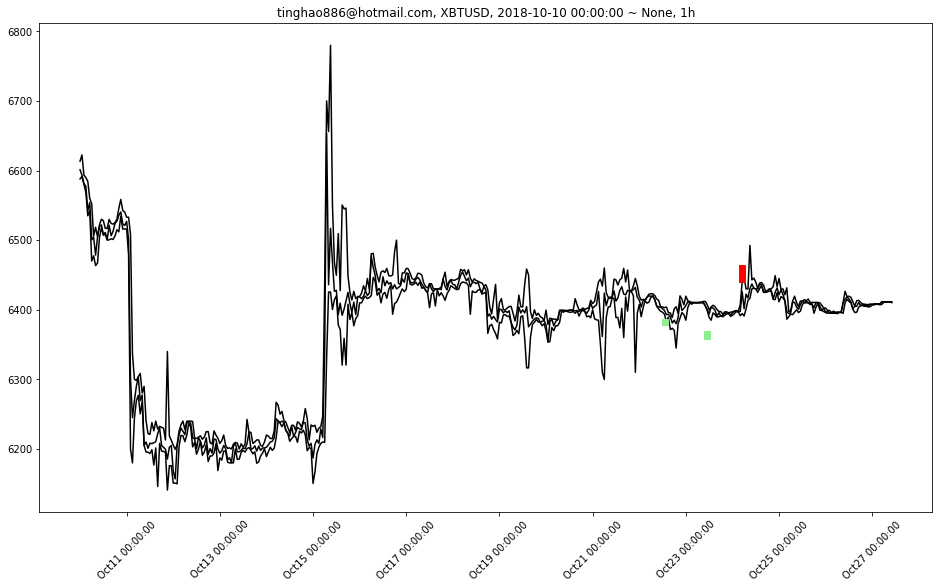

In [11]:
fig,ax = plt.subplots(figsize=(16,9))

ax.plot(df_market.DATETIME, df_market.close, color='k')
ax.plot(df_market.DATETIME, df_market.high, color='k')
ax.plot(df_market.DATETIME, df_market.low, color='k')

ax.plot(df_Exec_Trade_Buy.DATETIME, df_Exec_Trade_Buy['lastPx'], 's', color='red')
ax.plot(df_Exec_Trade_Sell.DATETIME, df_Exec_Trade_Sell['lastPx'], 's', color='lightgreen')
#ax.plot(df_Exec_New.DATETIME, df_Exec_New['price'], 'o', color='green')
#ax.plot(df_Exec_Canceled.DATETIME, df_Exec_Canceled['price'], '*', color='green')

from matplotlib.dates import DateFormatter

ax.xaxis.set_major_formatter(DateFormatter('%b%d %H:%M:%S'))
_=plt.xticks(rotation=45)
_=ax.set_title('%s, %s, %s ~ %s, %s' % (acc.account, symbol, startTime, endTime, bar_type))